In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import json
import os
import torch
import ssl
from mistralai import Mistral
from dotenv import load_dotenv
from transformers import AutoTokenizer, AutoModel

# Configuration du contexte SSL
ssl._create_default_https_context = ssl._create_unverified_context

# Chargement des variables d'environnement
load_dotenv()

True

In [17]:
def load_and_prepare_data(file_path):
    """
    Charge et prépare le dataset depuis metadata.jsonl
    
    Args:
        file_path (str): Chemin vers le fichier metadata.jsonl
        
    Returns:
        pd.DataFrame: DataFrame préparé avec les informations nutritionnelles
    """
    # Chargement des métadonnées
    with open(file_path, 'r') as f:
        metadata = [json.loads(line) for line in f]
    df = pd.DataFrame(metadata)
    
    # Calcul des ratios nutritionnels
    df['ratio_proteines'] = df['total_protein'] / (df['total_protein'] + df['total_fat'] + df['total_carb'])
    df['ratio_lipides'] = df['total_fat'] / (df['total_protein'] + df['total_fat'] + df['total_carb'])
    df['ratio_glucides'] = df['total_carb'] / (df['total_protein'] + df['total_fat'] + df['total_carb'])
    
    return df

def analyze_raw_data(df):
    """
    Effectue une analyse exploratoire des données brutes
    
    Args:
        df (pd.DataFrame): DataFrame d'entrée
    """
    # Colonnes nutritionnelles à analyser
    colonnes_nutrition = ['total_calories', 'total_fat', 'total_carb', 'total_protein']
    
    # Création d'une figure pour toutes les visualisations
    plt.figure(figsize=(20, 15))
    
    # 1. Boxplot pour total_calories
    plt.subplot(2, 3, 1)
    sns.boxplot(y=df['total_calories'])
    plt.title('Distribution des calories (données brutes)')
    plt.ylabel('total_calories')
    plt.xlabel('')
    
    stats_text_cal = "Statistiques calories:\n"
    stats_text_cal += f"Moyenne: {df['total_calories'].mean():.2f}\n"
    stats_text_cal += f"Écart-type: {df['total_calories'].std():.2f}\n"
    stats_text_cal += f"Skewness: {df['total_calories'].skew():.2f}\n"
    stats_text_cal += f"Kurtosis: {df['total_calories'].kurtosis():.2f}"
    plt.text(1.1, 0.5, stats_text_cal, transform=plt.gca().transAxes, verticalalignment='center')
    
    # 2. Boxplot pour fat, carb, protein
    plt.subplot(2, 3, 2)
    sns.boxplot(data=df[['total_fat', 'total_carb', 'total_protein']])
    plt.title('Distribution des macronutriments (données brutes)')
    plt.xticks(rotation=45)
    
    # 3. Matrice de corrélation
    plt.subplot(2, 3, 3)
    sns.heatmap(df[colonnes_nutrition].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Matrice de corrélation (données brutes)')
    
    # 4. Distribution des ratios nutritionnels
    plt.subplot(2, 3, 4)
    sns.boxplot(data=df[['ratio_proteines', 'ratio_lipides', 'ratio_glucides']])
    plt.title('Distribution des ratios nutritionnels (données brutes)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Affichage des statistiques détaillées
    print("\n=== STATISTIQUES DESCRIPTIVES (données brutes) ===")
    print(df[colonnes_nutrition].describe())
    
    print("\n=== TESTS DE NORMALITÉ (Shapiro-Wilk) ===")
    for col in colonnes_nutrition:
        stat, p_value = stats.shapiro(df[col])
        print(f"\n{col}:")
        print(f"Statistique: {stat:.3f}")
        print(f"p-value: {p_value:.3f}")
    
    # Analyse des valeurs manquantes
    print("\n=== VALEURS MANQUANTES ===")
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    # Analyse des valeurs extrêmes
    print("\n=== VALEURS EXTRÊMES ===")
    for col in colonnes_nutrition:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        print(f"\n{col}:")
        print(f"Nombre de valeurs extrêmes: {len(outliers)}")
        print(f"Valeurs min: {outliers.min():.2f}")
        print(f"Valeurs max: {outliers.max():.2f}")

def identify_outliers(df, columns):
    """
    Identifie les valeurs aberrantes en utilisant la méthode IQR
    
    Args:
        df (pd.DataFrame): DataFrame d'entrée
        columns (list): Liste des colonnes à vérifier pour les valeurs aberrantes
        
    Returns:
        pd.Series: Masque booléen des valeurs aberrantes
    """
    mask = pd.Series([False]*len(df))
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        mask = mask | (df[col] < lower_bound) | (df[col] > upper_bound)
    return mask

In [18]:
def split_data(df, test_size=0.2, random_state=42):
    """
    Divise les données en ensembles d'entraînement et de test
    
    Args:
        df (pd.DataFrame): DataFrame d'entrée
        test_size (float): Proportion des données à utiliser pour les tests
        random_state (int): Graine aléatoire pour la reproductibilité
        
    Returns:
        tuple: (X_train, X_test, y_train, y_test, df_clean)
    """
    # Définition des colonnes nutritionnelles
    nutritional_columns = ['total_calories', 'total_fat', 'total_carb', 'total_protein']
    
    # Suppression des valeurs aberrantes
    outliers_mask = identify_outliers(df, nutritional_columns)
    df_clean = df[~outliers_mask].reset_index(drop=True)
    print(f"Suppression de {outliers_mask.sum()} valeurs aberrantes. Taille du dataset nettoyé : {len(df_clean)}")
    
    # Préparation des features et de la cible
    X = df_clean[nutritional_columns]
    y = df_clean['total_calories']
    
    # Division des données avec stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=pd.qcut(y, q=5)
    )
    
    return X_train, X_test, y_train, y_test, df_clean

In [19]:
def analyze_clean_data(df_clean, X_train, X_test, y_train, y_test):
    """
    Effectue une analyse exploratoire des données nettoyées
    
    Args:
        df_clean (pd.DataFrame): DataFrame nettoyé
        X_train, X_test: Matrices de features
        y_train, y_test: Vecteurs cibles
    """
    # Colonnes nutritionnelles à analyser
    colonnes_nutrition = ['total_calories', 'total_fat', 'total_carb', 'total_protein']
    
    # Création d'une figure pour toutes les visualisations
    plt.figure(figsize=(20, 15))
    
    # 1. Boxplot pour total_calories
    plt.subplot(2, 3, 1)
    sns.boxplot(y=df_clean['total_calories'])
    plt.title('Distribution des calories (nettoyé)')
    plt.ylabel('total_calories')
    plt.xlabel('')
    
    # 2. Boxplot pour fat, carb, protein
    plt.subplot(2, 3, 2)
    sns.boxplot(data=df_clean[['total_fat', 'total_carb', 'total_protein']])
    plt.title('Distribution des macronutriments (nettoyé)')
    plt.xticks(rotation=45)
    
    # 3. Matrice de corrélation
    plt.subplot(2, 3, 3)
    sns.heatmap(df_clean[colonnes_nutrition].corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Matrice de corrélation (nettoyé)')
    
    # 4. Distribution des calories (train vs test)
    plt.subplot(2, 3, 4)
    sns.kdeplot(data=y_train, label='Train')
    sns.kdeplot(data=y_test, label='Test')
    plt.title('Distribution des calories (Train vs Test, nettoyé)')
    plt.legend()
    
    # 5. Distribution des ratios nutritionnels
    plt.subplot(2, 3, 5)
    sns.boxplot(data=df_clean[['ratio_proteines', 'ratio_lipides', 'ratio_glucides']])
    plt.title('Distribution des ratios nutritionnels (nettoyé)')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Affichage des statistiques détaillées
    print("\n=== STATISTIQUES DESCRIPTIVES (données nettoyées) ===")
    print(df_clean[colonnes_nutrition].describe())
    
    print("\n=== TAILLE DES ENSEMBLES TRAIN/TEST ===")
    print(f"Train: {len(X_train)} échantillons ({len(X_train)/len(df_clean)*100:.1f}%)")
    print(f"Test: {len(X_test)} échantillons ({len(X_test)/len(df_clean)*100:.1f}%)")
    
    # Comparaison des distributions train/test
    print("\n=== COMPARAISON DES DISTRIBUTIONS TRAIN/TEST ===")
    for col in colonnes_nutrition:
        ks_stat, ks_pval = stats.ks_2samp(X_train[col], X_test[col])
        mean_diff = abs(X_train[col].mean() - X_test[col].mean()) / X_train[col].mean() * 100
        std_diff = abs(X_train[col].std() - X_test[col].std()) / X_train[col].std() * 100
        print(f"\n{col}:")
        print(f"KS p-value: {ks_pval:.3f}")
        print(f"Différence moyenne: {mean_diff:.1f}%")
        print(f"Différence écart-type: {std_diff:.1f}%")

=== ANALYSE DES DONNÉES BRUTES ===


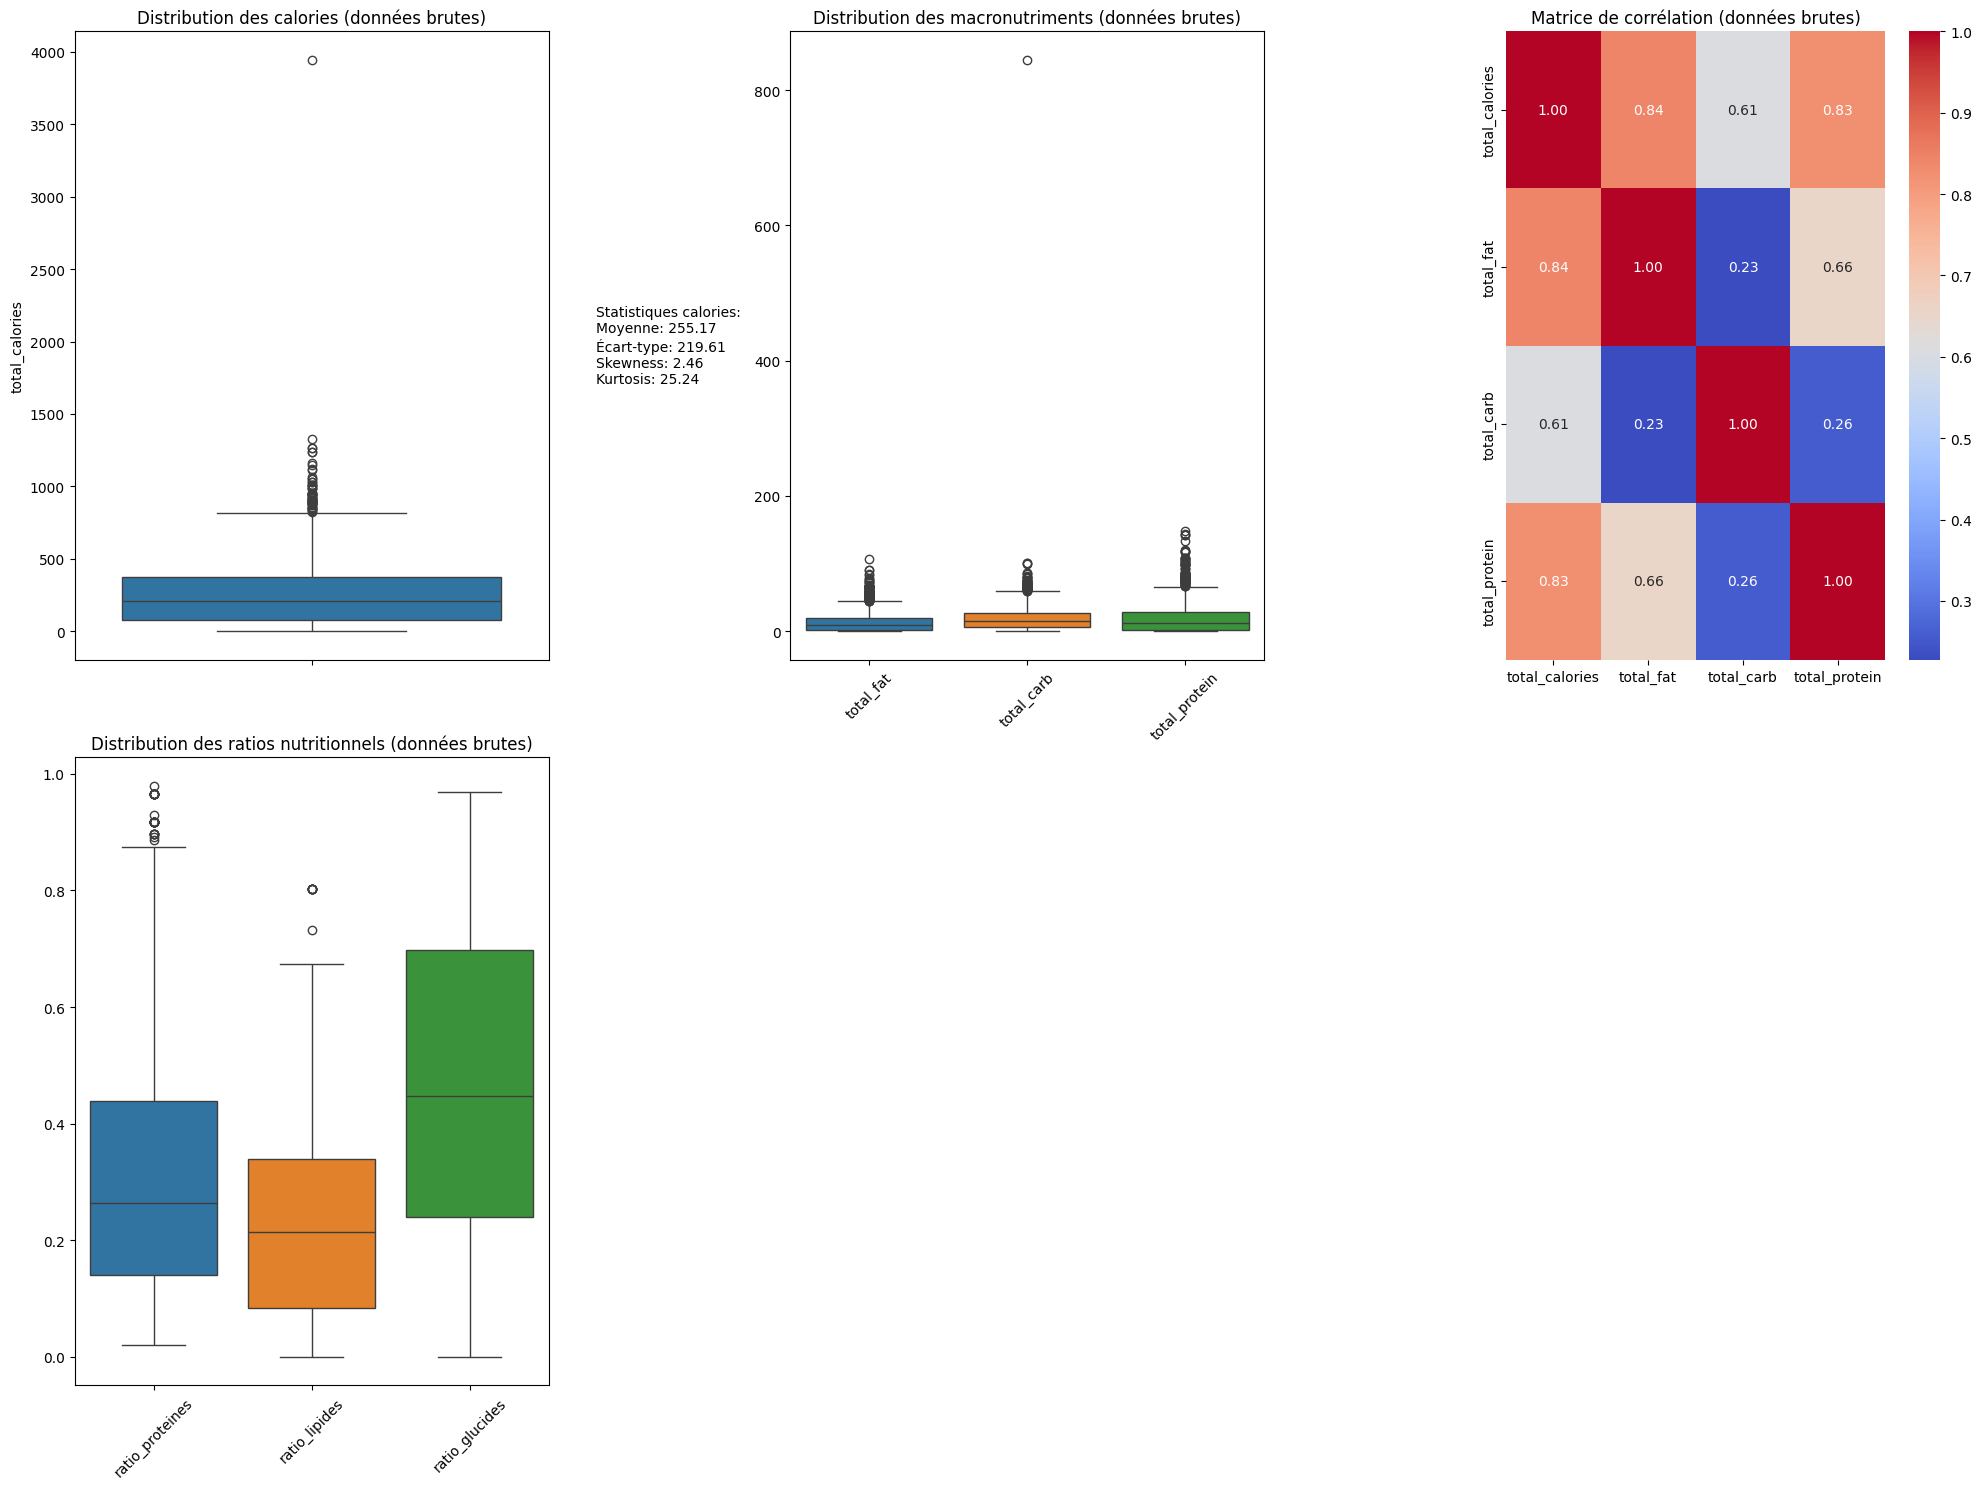


=== STATISTIQUES DESCRIPTIVES (données brutes) ===
       total_calories    total_fat   total_carb  total_protein
count     3260.000000  3260.000000  3260.000000    3260.000000
mean       255.169188    12.735442    19.398004      18.015538
std        219.614055    13.526882    21.606514      20.045720
min          1.150000     0.000000     0.000000       0.072000
25%         80.234392     1.848000     6.207500       2.135625
50%        209.285828     8.868902    15.361158      11.517166
75%        375.152466    19.038913    27.535250      28.050130
max       3943.325195   106.343002   844.568604     147.491821

=== TESTS DE NORMALITÉ (Shapiro-Wilk) ===

total_calories:
Statistique: 0.856
p-value: 0.000

total_fat:
Statistique: 0.837
p-value: 0.000

total_carb:
Statistique: 0.556
p-value: 0.000

total_protein:
Statistique: 0.815
p-value: 0.000

=== VALEURS MANQUANTES ===
Series([], dtype: int64)

=== VALEURS EXTRÊMES ===

total_calories:
Nombre de valeurs extrêmes: 59
Valeurs min: 821.

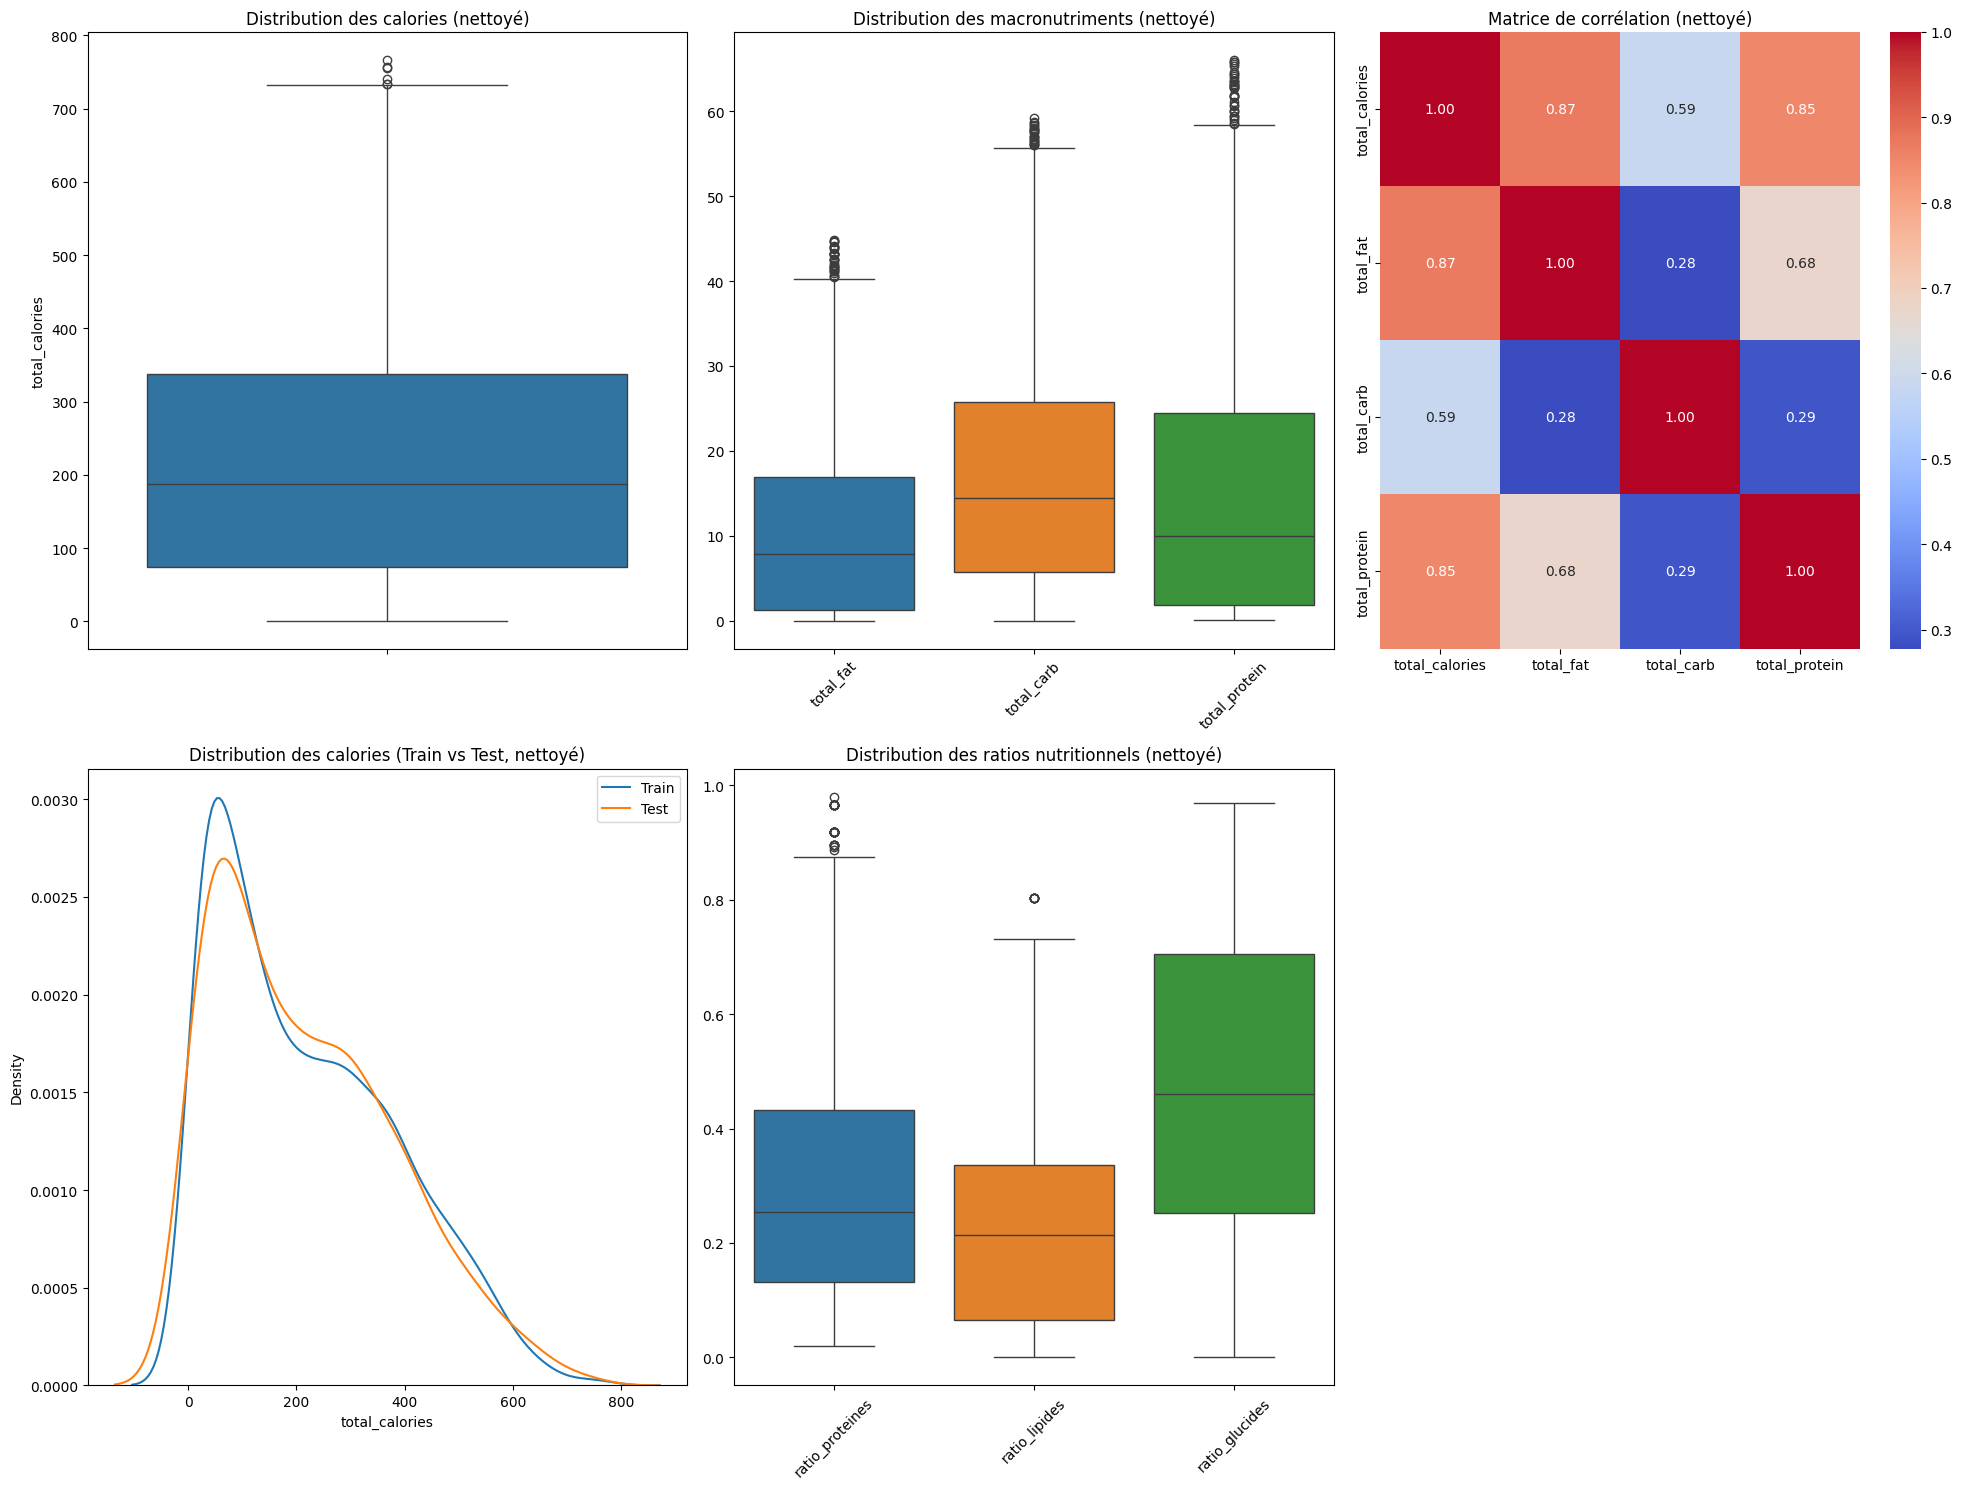


=== STATISTIQUES DESCRIPTIVES (données nettoyées) ===
       total_calories    total_fat   total_carb  total_protein
count     3018.000000  3018.000000  3018.000000    3018.000000
mean       218.703473    10.774654    17.492112      15.055438
std        165.065243    10.481510    13.970577      15.439049
min          1.150000     0.000000     0.000000       0.072000
25%         74.360001     1.268470     5.760243       1.885000
50%        187.006485     7.847946    14.407295       9.987000
75%        337.733643    16.899008    25.738860      24.512444
max        766.626526    44.793999    59.220001      66.063805

=== TAILLE DES ENSEMBLES TRAIN/TEST ===
Train: 2414 échantillons (80.0%)
Test: 604 échantillons (20.0%)

=== COMPARAISON DES DISTRIBUTIONS TRAIN/TEST ===

total_calories:
KS p-value: 0.987
Différence moyenne: 0.5%
Différence écart-type: 0.2%

total_fat:
KS p-value: 0.915
Différence moyenne: 0.1%
Différence écart-type: 1.2%

total_carb:
KS p-value: 0.742
Différence moyenne: 2

In [20]:
# Chargement et préparation des données
metadata_path = "food-nutrients/metadata.jsonl"
df = load_and_prepare_data(metadata_path)

# Analyse des données brutes
print("=== ANALYSE DES DONNÉES BRUTES ===")
analyze_raw_data(df)

# Division des données
print("\n=== DIVISION DES DONNÉES ===")
X_train, X_test, y_train, y_test, df_clean = split_data(df)

# Analyse des données nettoyées
print("\n=== ANALYSE DES DONNÉES NETTOYÉES ===")
analyze_clean_data(df_clean, X_train, X_test, y_train, y_test)

In [21]:
def load_metadata(file_path, num_samples=None):
    dishes_data = []
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if num_samples is not None and i >= num_samples:
                break
            data = json.loads(line)
            dishes_data.append({
                'id': data['id'],
                'split': data['split'],  # <-- AJOUTE CETTE LIGNE
                'ingredients': data['ingredients'],
                'total_calories': data['total_calories'],
                'total_mass': data['total_mass'],
                'total_fat': data['total_fat'],
                'total_carb': data['total_carb'],
                'total_protein': data['total_protein']
            })
    return dishes_data

def create_ingredient_description(ingredients):
    """
    Crée une description textuelle riche pour un plat complet avec tous ses ingrédients
    en utilisant l'API Mistral AI
    
    Args:
        ingredients (list): Liste des ingrédients du plat
        
    Returns:
        str: Description textuelle complète du plat
    """
    # Initialisation du client Mistral
    api_key = os.getenv("MISTRAL_API_KEY")
    if not api_key:
        raise ValueError("La clé API Mistral n'est pas définie dans le fichier .env")
    
    client = Mistral(api_key=api_key)
    model = "mistral-large-latest"
    
    # Création du prompt pour Mistral
    ingredients_text = "\n".join([
        f"- {ing['name']} ({ing['grams']}g) : {ing['calories']:.1f} kcal, {ing['fat']:.1f}g fat, {ing['carb']:.1f}g carbs, {ing['protein']:.1f}g protein"
        for ing in ingredients
    ])
    
    prompt = f"""As a nutritionist, analyze this dish using these ingredients and their nutritional information:

{ingredients_text}

Balanced meal criteria:
- Total calories: 500-800 kcal
- Protein: 20-30g (25-30% of calories)
- Carbs: 45-65g (45-55% of calories)
- Fat: 15-25g (25-35% of calories)

Generate an EXTREMELY short description that:
1. Compares the nutritional values with these balance criteria
2. Suggests ONE simple adjustment to improve balance
3. Avoids unnecessary details and repetitions

IMPORTANT: 
- Your response must be VERY short (maximum 50 tokens)
- Use short and direct sentences
- Avoid detailed explanations
- Mention only one adjustment at a time
- Don't repeat the same information"""
    
    # Appel de l'API Mistral
    chat_response = client.chat.complete(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "You are an expert nutritionist analyzing dishes. You must provide VERY short and direct nutritional descriptions. Avoid unnecessary details and repetitions. IMPORTANT: Your response must be extremely short (maximum 50 tokens)."
            },
            {
                "role": "user",
                "content": prompt
            }
        ]
    )
    
    return chat_response.choices[0].message.content

def generate_text_embeddings_transformer(texts):
    """
    Génère des embeddings pour une liste de textes en utilisant BERT
    
    Args:
        texts (list): Liste de textes (ingrédients)
        
    Returns:
        numpy.ndarray: Matrice d'embeddings pour chaque texte
    """
    # Chargement du modèle et du tokenizer
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_name = "bert-base-uncased"  # Modèle BERT pré-entraîné en anglais
    
    try:
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModel.from_pretrained(model_name).to(device)
    except Exception as e:
        print(f"Erreur lors du chargement du modèle : {e}")
        print("Tentative de téléchargement manuel du modèle...")
        cache_dir = os.path.expanduser("~/.cache/huggingface")
        os.makedirs(cache_dir, exist_ok=True)
        tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir=cache_dir)
        model = AutoModel.from_pretrained(model_name, cache_dir=cache_dir).to(device)
    
    # Tokenization du texte
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}
    
    # Génération des embeddings
    with torch.no_grad():
        outputs = model(**encoded_input)
        # Utilisation de la moyenne des embeddings de la dernière couche cachée
        text_features = outputs.last_hidden_state.mean(dim=1)
        # Normalisation des embeddings
        text_features /= text_features.norm(dim=-1, keepdim=True)
    
    return text_features.cpu().numpy()

In [22]:
# Chargement des données pour l'analyse textuelle
print("\n=== ANALYSE TEXTUELLE DES PLATS ===")
dishes_data = load_metadata(metadata_path)

# Affichage des informations pour chaque plat
for i, dish in enumerate(dishes_data, 1):
    print(f"\n{'='*80}")
    print(f"Plat {i} (ID: {dish['id']})")
    print(f"{'='*80}")
    
    print("\nIngrédients:")
    print("-" * 80)
    for ingredient in dish['ingredients']:
        print(f"• {ingredient['name']} ({ingredient['grams']}g)")
        print(f"  - Calories: {ingredient['calories']:.1f} kcal")
        print(f"  - Lipides: {ingredient['fat']:.1f}g")
        print(f"  - Glucides: {ingredient['carb']:.1f}g")
        print(f"  - Protéines: {ingredient['protein']:.1f}g")
    
    print("\nTotaux du plat:")
    print("-" * 80)
    print(f"• Masse totale: {dish['total_mass']:.1f}g")
    print(f"• Calories totales: {dish['total_calories']:.1f} kcal")
    print(f"• Lipides totaux: {dish['total_fat']:.1f}g")
    print(f"• Glucides totaux: {dish['total_carb']:.1f}g")
    print(f"• Protéines totales: {dish['total_protein']:.1f}g")

# Création des descriptions enrichies pour chaque plat
print("\n=== GÉNÉRATION DES DESCRIPTIONS NUTRITIONNELLES ===")
enriched_descriptions = []
for dish in dishes_data:
    try:
        description = create_ingredient_description(dish['ingredients'])
        enriched_descriptions.append(description)
        print(f"\nDescription pour le plat {dish['id']}:")
        print(description)
    except Exception as e:
        print(f"Erreur lors de la génération de la description : {e}")
        enriched_descriptions.append("Description non disponible - Erreur API")

# Génération des embeddings de texte
print("\n=== GÉNÉRATION DES EMBEDDINGS DE TEXTE ===")
text_embeddings = generate_text_embeddings_transformer(enriched_descriptions)
print(f"\nForme des embeddings de texte : {text_embeddings.shape}")
print("(nombre d'ingrédients, dimension de l'embedding Transformer)")

# Affichage des premiers embeddings pour vérification
print("\nPremiers embeddings générés :")
print(text_embeddings[0][:5])  # Affiche les 5 premières dimensions du premier embedding


=== ANALYSE TEXTUELLE DES PLATS ===

Plat 1 (ID: dish_1556572657)

Ingrédients:
--------------------------------------------------------------------------------
• olives (36.0g)
  - Calories: 41.4 kcal
  - Lipides: 3.9g
  - Glucides: 2.3g
  - Protéines: 0.3g

Totaux du plat:
--------------------------------------------------------------------------------
• Masse totale: 36.0g
• Calories totales: 41.4 kcal
• Lipides totaux: 3.9g
• Glucides totaux: 2.3g
• Protéines totales: 0.3g

Plat 2 (ID: dish_1556573514)

Ingrédients:
--------------------------------------------------------------------------------
• mixed greens (23.0g)
  - Calories: 6.4 kcal
  - Lipides: 0.1g
  - Glucides: 1.2g
  - Protéines: 0.5g

Totaux du plat:
--------------------------------------------------------------------------------
• Masse totale: 23.0g
• Calories totales: 6.4 kcal
• Lipides totaux: 0.1g
• Glucides totaux: 1.2g
• Protéines totales: 0.5g

Plat 3 (ID: dish_1556575014)

Ingrédients:
-----------------------

In [ ]:
def prepare_training_data(file_path):
    """
    Prépare les données d'entraînement à partir du fichier metadata.jsonl
    
    Args:
        file_path (str): Chemin vers le fichier metadata.jsonl
        
    Returns:
        tuple: (X_train, X_test, y_train, y_test, descriptions_train, descriptions_test)
    """
    # Chargement des données
    print("Chargement des données...")
    data = load_metadata(file_path, num_samples=None)  # None pour charger toutes les données
    
    # Séparation des données en train et test
    train_data = [item for item in data if item['split'] == 'train']
    test_data = [item for item in data if item['split'] == 'test']

    print(f"Nombre de plats d'entraînement : {len(train_data)}")
    print(f"Nombre de plats de test : {len(test_data)}")
    
    # Génération des descriptions pour chaque plat
    print("\nGénération des descriptions pour les données d'entraînement...")
    descriptions_train = [create_ingredient_description(item['ingredients']) for item in train_data]
    
    print("Génération des descriptions pour les données de test...")
    descriptions_test = [create_ingredient_description(item['ingredients']) for item in test_data]
    
    # Extraction des valeurs nutritionnelles totales par plat
    y_train = np.array([[item['total_calories'], 
                        item['total_fat'], 
                        item['total_carb'], 
                        item['total_protein']] for item in train_data])
    
    y_test = np.array([[item['total_calories'], 
                       item['total_fat'], 
                       item['total_carb'], 
                       item['total_protein']] for item in test_data])
    
    # Génération des embeddings pour les descriptions
    print("\nGénération des embeddings pour les descriptions d'entraînement...")
    X_train = generate_text_embeddings_transformer(descriptions_train)
    
    print("Génération des embeddings pour les descriptions de test...")
    X_test = generate_text_embeddings_transformer(descriptions_test)
    
    return X_train, X_test, y_train, y_test, descriptions_train, descriptions_test

# Fonction pour entraîner et évaluer le modèle
def train_and_evaluate_model(X_train, X_test, y_train, y_test, descriptions_train, descriptions_test):
    """
    Entraîne et évalue le modèle de prédiction des valeurs nutritionnelles
    
    Args:
        X_train, X_test: Matrices d'embeddings
        y_train, y_test: Matrices des valeurs nutritionnelles
        descriptions_train, descriptions_test: Listes des descriptions
    """
    from sklearn.multioutput import MultiOutputRegressor
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    
    # Création du modèle
    base_model = LinearRegression()
    model = MultiOutputRegressor(base_model)
    
    # Entraînement du modèle
    print("\nEntraînement du modèle...")
    model.fit(X_train, y_train)
    
    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Évaluation pour chaque variable nutritionnelle
    metrics = ['calories', 'fat', 'carb', 'protein']
    print("\n=== Métriques d'évaluation ===")
    
    for i, metric in enumerate(metrics):
        print(f"\n{metric.upper()}:")
        print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train[:, i], y_train_pred[:, i])):.2f}")
        print(f"Train R²: {r2_score(y_train[:, i], y_train_pred[:, i]):.3f}")
        print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test[:, i], y_test_pred[:, i])):.2f}")
        print(f"Test R²: {r2_score(y_test[:, i], y_test_pred[:, i]):.3f}")
    
    # Visualisation des prédictions vs valeurs réelles
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.scatter(y_test[:, i], y_test_pred[:, i], alpha=0.5)
        plt.plot([y_test[:, i].min(), y_test[:, i].max()], 
                 [y_test[:, i].min(), y_test[:, i].max()], 'r--', lw=2)
        plt.xlabel(f'Valeurs réelles {metric}')
        plt.ylabel(f'Prédictions {metric}')
        plt.title(f'{metric.capitalize()}: Prédictions vs Valeurs réelles')
    
    plt.tight_layout()
    plt.show()
    
    return model, y_test_pred

# Exécution du pipeline complet
print("Démarrage du pipeline d'entraînement...")
X_train, X_test, y_train, y_test, descriptions_train, descriptions_test = prepare_training_data('food-nutrients/metadata.jsonl')

# Affichage des dimensions pour vérification
print(f"\nDimensions des données :")
print(f"X_train shape : {X_train.shape}")
print(f"X_test shape : {X_test.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"y_test shape : {y_test.shape}")

# Affichage d'un exemple pour vérification
print("\nExemple d'entraînement :")
print(f"Description : {descriptions_train[0]}")
print(f"Valeurs nutritionnelles totales du plat : {y_train[0]}")

# Entraînement et évaluation du modèle
model, y_test_pred = train_and_evaluate_model(X_train, X_test, y_train, y_test, descriptions_train, descriptions_test)

Démarrage du pipeline d'entraînement...
Chargement des données...
Nombre de plats d'entraînement : 0
Nombre de plats de test : 10

Génération des descriptions pour les données d'entraînement...
Génération des descriptions pour les données de test...


SDKError: API error occurred: Status 429
{"message":"Requests rate limit exceeded"}